[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/B-RAINS_demo.ipynb)

# <center> <font color='blue'> **Boosted Transfer Learning for Passive Microwave Precipitation Retrievals** <center>

#### <center> <font color='balck'> Buddha Subedi, Mahyar Garshasbi, Ardeshir Ebtehaj <center>
#### <center> Saint Anthony Falls Laboratory, Department of Civil Environmental and Geo- Engineering,
#### <center> University of Minnesota <center>
#### <center> Date: May, 2025 (rev 01)

---
<p align="justify"> This notebook representes the results of an algorithm, called the Boosted tRansfer-leArning for PMW precIpitationN Retrievals (B-RAINS) for passive microwave retrieval of precipitation. B-RAINS enables (i) the integration of the information content from ESMs into the retrieval process and (ii) the fusion of multi-satellite observations across varying spatial and temporal resolutions through meta-model learning. The architecture leverages transfer learning by incorporating low-level priors from ESMs and refining them with high-level features derived from satellite-based active retrievals, enhancing accuracy in regions and periods with limited training data. The algorithm first detects the precipitation occurrence and phase and then estimates its rate, while conditioning the results to some key cloud microphysical and environmental variables as further explained later on in Section 1.2. Through ensemble meta-modeling, B-RAINS combines data from multiple spaceborne radars operating at Ka, Ku, and W bands to improve the detection of rainfall and snowfall. Application and validation using data from the Global Precipitation Measurement (GPM) mission and CloudSat's Cloud Profiling Radar (CPR) show that B-RAINS achieves comparable accuracy to existing methods for rain retrievals and delivers substantial improvements in global snowfall estimates when benchmarked against version V07 of the official GPM data products and Multi-Radar/Multi-Sensor System (MRMS) precipitation estimates over the contiguous United States.

This notebook is organized as follows. Section 1, describes the data including the GPM and CloudSat products as well as the ERA5 reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). Section 2 describes the methodolgy for training the networks, and the last section provides an example for precipitation orbital retrieval using the proposed algorithm.

# **1. Data**

**1.1** **Data Description**

In this study, we considered coincidences of GMI and CPR from April 2014 to July 2019, and coincidences of GMI and DPR data in 2015 and 2023. Furthermore, ancillary information related to atmospheric conditions, surface types and topography are added to all coincidences using the [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) reanalysis products -- available at spatial resolution of 31km and [GTOPO](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-30-arc-second-elevation-gtopo30) -- available at spatial resolution of 1km.

**Atmospheric Variables**
*   tclw = Total Column Cloud Liquid Water ($\rm kg/m^2$)
*   tciw = Total Column Cloud Ice Water ($\rm kg/m^2$)
*   tcwv = Total Column Water Vapor ($\rm kg/m^2$)
*   cape = Convective Available Potential Energy ($\rm j/kg$)
*   t2m = 2m air temperature ($\rm K$)
*   u10 = 10m u-component of wind ($\rm m/s$)
*   v10 = 10m v-component of wind ($\rm m/s$)
*   tcslw = Total Column Supercooled Liquid Water ($\rm \frac{kg}{m^2}$)
*   tcw = Total Column Water ($\rm \frac{kg}{m^3}$)
*   cin = Convective Inhibition ($\rm j/kg$)

**Surface Type Variables**
*   lsm = LandSeaMask
*   siconc = Sea Ice Area Fraction
*   sd = Snow Depth ($\rm m$)
*   asn = Snow Albedo (-)
*   rsn = Snow Density
*   swvl1 = Volumetric Soil Water Layer1 (-)

**Orographic Variables**
* Elevation ($\rm m$)
* Aspect

The GMI-CPR coincidences rely on the level-II CloudSat products (R05) including the 2C-PRECIP-COLUMN  and the 2C-SNOW-PROFILE that contains near-surface rain and snowfall rates.  To avoid ground-clutter contamination over complex elevated terrains, the near-surface snowfall rate is reported at 3rd (5th) radar bin above the oceans (land) at 720 (1200) m above the surface.

The 2A-DPR product, retrieved from Ku-band reflectivity, consists the near-surface precipitation phase and its intensity. It should be noted that the DPR algorithm uses precipitation phase at the lowest radar range gate uncontaminated by surface clutter, which may be 0.5--2.0 km above the surface (even over oceans).

Figure 1, represents the way the coincidences between GMI and CloudSat profiling radar (CPR) and GMI and DPR are collected. For more details with respect to the CloudSat and GMI please refer to ([2](https://journals.ametsoc.org/view/journals/hydr/22/7/JHM-D-20-0296.1.xml))

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/coincidence_image.png?raw=1" alt="Coincidence Image" width="800"/><br/>
  <em><strong>Figure 1.</strong> Schematic of a CloudSat-GPM coincidence segment (left), and DPR-GMI coincidence (right).</em>
</div>

Resolution mismatches between input and output data sources can introduce information redundancy and exacerbate the inherent non-uniqueness of the inverse problem in precipitation retrievals. In this study, all retrievals are performed at the nominal footprint resolution of GMI pixels (5.1$\times$13.2~km). The total number of samples, after harmonization, in phase detection (rate estimation) is 7,000,000 from ERA5 (2,500,000 rain, 1,000,000 snow), 240,800 from CPR (47,123 snow), and 2,800,000 from DPR (1,700,000 rain) for DPR coincidences. The data sets are partitioned into 70, 15, and 15 percent for training, testing, and validation.

## **1.2 Database Organization and Loading**

**Inputs for the phase detection and rate estimation are as follows:**
> **Inputs:**

*   $\text{TB} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $ \text{tciw} = X_{train}(:,14)$ (Cloud Liquid Water Path)
*   $\text{tclw} = X_{train}(:,15)$ (Cloud Ice Water Path)
*   $\text{tcwv} = X_{train}(:,16)$ (2-meter Air Temperature)
*   $\text{t2m} = X_{train}(:,17)$ (Water Vapor Path)
*   $\text{cape} = X_{train}(:,18)$ (Convective Potential Energy)

*   $\text{u10} = X_{train}(:,19)$ (10m u-component of wind)
*   $ \text{v10} = X_{train}(:,20)$ (10m v-component of wind)
*   $\text{skt} = X_{train}(:,21)$ (Skin Temperature)
*   $\text{asn} = X_{train}(:,22)$ (Snow Albedo)
*   $\text{rsn} = X_{train}(:,23)$ (Snow Density)
*   $\text{cin} = X_{train}(:,24)$ (Convective Inhibition)

*   $\text{sd} = X_{train}(:,25)$ (Snow Depth)
*   $ \text{tcslw} = X_{train}(:,26)$ (Total Column Supercooled Liquid Water)
*   $\text{tcw} = X_{train}(:,27)$ (Total Column Water)
*   $\text{swvl1} = X_{train}(:,28)$ (Snow Albedo)
*   $\text{lsm} = X_{train}(:,29)$ (Snow Density)
*   $\text{siconc} = X_{train}(:,30)$ (Convective Inhibition)

*   $\text{Latitude} = X_{train}(:,31)$ (Snow Depth)
*   $ \text{Longitude} = X_{train}(:,32)$ (Total Column Supercooled Liquid Water)
*   $\text{Month} = X_{train}(:,33)$ (Total Column Water)
*   $\text{Day} = X_{train}(:,34)$ (Snow Albedo)
*   $\text{Elevation} = X_{train}(:,35)$ (Snow Density)
*   $\text{Aspect} = X_{train}(:,36)$ (Convective Inhibition)


> **Outputs:**

*   Output of the phase network is a vector containing three integer values **0 (no precipitation)**, **1 (rainfall)**, and **2 (snowfall)**

**For the precipitation estimation, the inputs and outputs are as follows:**

> **Inputs:**

*    The same set of input features that was used for classification is used here as well

> **Outputs**:

*   Output of the estimation network is a vector containing rainfall/snowfall rate [$\rm mm.hr^{-1}$].

## **1.3 Code**
To run this notebook on Google Colab, you need to clone this repository. This is a demo code that has a complete process for training B-RAINS model on a subset of our dataset.

In [ ]:
# Clone the repo
import os
!git clone https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS.git
os.chdir("Microwave_Precipitation_Retrievals_from_B-RAINS")

Cloning into 'Microwave_Precipitation_Retrievals_from_B-RAINS'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 315 (delta 23), reused 3 (delta 3), pack-reused 274 (from 4)
Receiving objects: 100% (315/315), 92.51 MiB | 29.93 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [ ]:
# Import Necessary Packages
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from pathlib import Path
import xgboost as xgb
import os
import scipy.io
import pmw_utils
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
import scipy.stats as stats
from scipy.interpolate import interp1d
importlib.reload(pmw_utils)
from pmw_utils import plot_confusion_matrix, BRAINS_model

In [ ]:
paths_phase = {
    'cpr_train': 'data/df_cpr_phase_train.npz',
    'cpr_test':  'data/df_cpr_phase_test.npz',
    'dpr_train': 'data/df_dpr_phase_train.npz',
    'dpr_test':  'data/df_dpr_phase_test.npz',
    'era5_train': 'data/df_era5_phase_train.npz',
    'era5_test':  'data/df_era5_phase_test.npz'
}
data = {k: np.load(p) for k, p in paths_phase.items()}
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}
df_cpr_phase_train = dfs['cpr_train']
df_cpr_phase_test  = dfs['cpr_test']
df_dpr_phase_train = dfs['dpr_train']
df_dpr_phase_test  = dfs['dpr_test']
df_era5_phase_train = dfs['era5_train']
df_era5_phase_test  = dfs['era5_test']

In [ ]:
paths_rate = {
    'cpr_snow_rate_train': 'data/df_csat_snow_rate_train.npz',
    'cpr_snow_rate_test':  'data/df_csat_snow_rate_test.npz',
    'dpr_rain_rate_train': 'data/df_dpr_rain_rate_train.npz',
    'dpr_rain_rate_test':  'data/df_dpr_rain_rate_test.npz',
    'era5_snow_rate_train': 'data/df_era5_snow_rate_train.npz',
    'era5_snow_rate_test':  'data/df_era5_snow_rate_test.npz',
    'era5_rain_rate_train': 'data/df_era5_rain_rate_train.npz',
    'era5_rain_rate_test':  'data/df_era5_rain_rate_test.npz'
}

# Load .npz files
data = {k: np.load(p) for k, p in paths_rate.items()}

# Convert to DataFrames
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}

# Assign to variables
df_cpr_snow_rate_train = dfs['cpr_snow_rate_train']
df_cpr_snow_rate_test  = dfs['cpr_snow_rate_test']
df_dpr_rain_rate_train = dfs['dpr_rain_rate_train']
df_dpr_rain_rate_test  = dfs['dpr_rain_rate_test']
df_era5_snow_rate_train = dfs['era5_snow_rate_train']
df_era5_snow_rate_test  = dfs['era5_snow_rate_test']
df_era5_rain_rate_train = dfs['era5_rain_rate_train']
df_era5_rain_rate_test  = dfs['era5_rain_rate_test']

In [ ]:
paths_cdf = {
    'cdf_rain': 'data/df_cdf_rain.npz',
    'cdf_snow':  'data/df_cdf_snow.npz'
}
data = {k: np.load(p) for k, p in paths_cdf.items()}
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}
df_cdf_rain = dfs['cdf_rain']
df_cdf_snow  = dfs['cdf_snow']

# **2.  Methodology**
Boosted tRansfer-leArning for precIpitatioN RetrievalS (B-RAINS) presents an ensemble learning architecture that stacks parallel XGBoost base learners and combines their inference through a meta-model. initially, a finite set of top boosters is trained exclusively on ERA5 data, after which these boosters are frozen -- that is, their structure, including the number of trees, depth, nodes, and splitting criteria, is fixed. Additional bottom boosters are then appended and trained on satellite-based observations to capture the finer-scale information embedded in active retrievals. Each base learner is satellite-specific and tailored to either DPR or CPR data. In the classification stage, the base learners' output class probabilities represent clear, snowy, and rainy from both ERA5-CPR and ERA5-DPR, which are then fused using an XGBoost meta-model, producing the final precipitation phase prediction. Following phase classification, two additional parallel base learners estimate rain and snow rates, respectively.

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/Fig_01.png?raw=1" alt="B-RAINS Architecture" width="700"/><br/>
  <em>
    <strong>Figure 2.</strong> The architecture of the Boosted tRansfer-leArning for precIpitatioN RetrievalS (B-RAINS) that stacks parallel XGBoost base learners and combines their inference through a meta-model. Step 1 detects the precipitation occurrence and phase, and Step 2 estimates the rain and snow rate, with the subscripts <code>L</code> and <code>R</code> denoting labels and rates of the data sets. The retrievals transfer the learning from ERA5 to satellite through incremental training of the base learners in both steps. After learning ERA5, the number of parallel trees, tree booster numbers, depths, and splitting nodes are frozen (FZ) for the top part of the decision trees.
  </em>
</div>

Figure 3 displays precipitation retrievals for a snowstorm and a rainstorm observed by GMI orbit 027551 over the Southern and Indian Oceans. The first column shows results using only $n_e = 90$ boosting rounds, trained exclusively on ERA5 precipitation flags and rates. When additional $n_s$ boosting trees are incrementally added to capture the information content of satellite data pairs, finer spatial details and higher intensity values emerge. Concurrently, low-intensity precipitation at the storm peripheries, initially shaped by learning from the coarse resolution of ERA5, gradually diminishes, as B-RAINS adapts and partially ``forgets'' the low-resolution ERA5 data in favor of a higher fidelity to satellite information.

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/Fig_03.png?raw=1" alt="Impact of Transfer Learning" width="800"/><br/>
  <em>
    <strong>Figure 3.</strong> Impacts of transfer learning on retrievals of a rain storm (a–e) and a snow storm (f–j) over the Southern and Indian Oceans on 01/04/2019 (orbit 027551), with <code>n_e</code> and <code>n_s</code> denoting the boosting rounds used to learn ERA5 (before freezing) and satellite precipitation (after freezing), where the ERA5 simulations and DPR retrievals are shown for visual comparisons.
  </em>
</div>

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/Fig_04.png?raw=1" alt="Confusion Metrics" width="800"/><br/>
  <em>
    <strong>Figure 4.</strong> The confusion metrics of the B-RAINS detection step, stratified for the test dataset over different surface types.
  </em>
</div>

<div align="center">
  <img src="https://i.postimg.cc/zGbVp28R/Fig-05.png)](https://postimg.cc/nXxFhksH" alt="Scatter Plot" width="800"/><br/>
  <em>
    <strong>Figure 5.</strong> Density scatter plots for the rainfall (a) and snowfall (b) retrievals against the DPR and CPR test sets, with RMSE values (c) stratified by surface types after cumulative density matching. RMSE values are also shown for equal-sized combined test sets: DPR+ERA5 and CPR+ERA5 in the panel c.
  </em>
</div>

## **2.1  Training B-RAINS**

### **2.1.1  ERA5-CPR base learner for classification**

Stage 1: Learning ERA5 labels

[0]	train-merror:0.13079	test-merror:0.16793
[1]	train-merror:0.12409	test-merror:0.16314
[2]	train-merror:0.11918	test-merror:0.16043
[3]	train-merror:0.11516	test-merror:0.16079
[4]	train-merror:0.11077	test-merror:0.15914
[5]	train-merror:0.10891	test-merror:0.15807
[6]	train-merror:0.10564	test-merror:0.15629
[7]	train-merror:0.10371	test-merror:0.15664
[8]	train-merror:0.10100	test-merror:0.15586
[9]	train-merror:0.09907	test-merror:0.15657
[10]	train-merror:0.09713	test-merror:0.15679
[11]	train-merror:0.09498	test-merror:0.15550
[12]	train-merror:0.09245	test-merror:0.15450
[13]	train-merror:0.09127	test-merror:0.15500
[14]	train-merror:0.08986	test-merror:0.15400
[15]	train-merror:0.08814	test-merror:0.15407
[16]	train-merror:0.08680	test-merror:0.15286
[17]	train-merror:0.08496	test-merror:0.15264
[18]	train-merror:0.08148	test-merror:0.15307
[19]	train-merror:0.07993	test-merror:0.15371
[20]	train-merror:0.07745	test-merror:0.15286
[21]	train-merror:0.07520	test-merror:0.1519

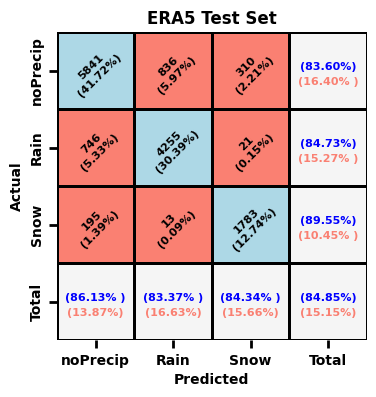

In [ ]:
input_vars = ['10v', '10h', '18v', '18h','23v','36v', '36h', '89v', '89h', '166v', '166h','183-3', '183-7',
              'tciw','tclw','tcwv','t2m','cape','u10', 'v10', 'skt','asn', 'rsn', 'cin',
              'sd', 'tcslw','tcw','swvl1','lsm', 'siconc', 'Latitude','Longitude', 'Month', 'Day', 'mean_aspect', 'elevation_mean']

# Train/test split
x_train_era5 = df_era5_phase_train[input_vars]
y_train_era5 = df_era5_phase_train['Prcp flag']

x_test_era5 = df_era5_phase_test[input_vars]
y_test_era5 = df_era5_phase_test['Prcp flag']

# Create DMatrix for XGBoost
dtrain_era5 = xgb.DMatrix(x_train_era5, label=y_train_era5)
dtest_era5 = xgb.DMatrix(x_test_era5, label=y_test_era5)

# Evaluation set
evals = [(dtrain_era5, 'train'), (dtest_era5, 'test')]

# Model parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'reg_alpha': 0.095,
    'reg_lambda': 7.843,
    'max_depth': 10,
    'num_parallel_tree': 3,
    'learning_rate': 0.330808,
    'gamma': 0.661776,
    'verbosity': 0
}

# Train the model
booster_era5 = xgb.train(
    params=params,
    dtrain=dtrain_era5,
    evals=evals,
    num_boost_round=30,
    verbose_eval=True
)

# Predict
y_pred_era5 = booster_era5.predict(dtest_era5)

# Plot confusion matrix
plot_confusion_matrix(y_test_era5, y_pred_era5, 'Predicted', 'Actual', 'ERA5 Test Set')

Stage 2: Finetuning model trained on ERA5 labels with CPR labels

In second round of training, architecture of trees trained on the ERA5 will be frozen -- that is, their structure, including the number of trees, depth, nodes, and splitting criteria, is fixed. Additional bottom boosters are then appended and trained on satellite-based observations to capture the finer-scale information embedded in active retrievals.

In [ ]:
x_train_cpr = df_cpr_phase_train[input_vars]
y_train_cpr = df_cpr_phase_train['Prcp flag']

x_test_cpr = df_cpr_phase_test[input_vars]
y_test_cpr = df_cpr_phase_test['Prcp flag']

# Class weights
classes = np.unique(y_train_cpr)
class_weights = {0: 1, 1: 1.167, 2: 1.766}

# Sample weights
sample_weights_cpr = y_train_cpr.map(lambda x: class_weights[classes.tolist().index(x)])

# DMatrix creation
dtrain_cpr = xgb.DMatrix(x_train_cpr, label=y_train_cpr, weight=sample_weights_cpr)
dtest_cpr = xgb.DMatrix(x_test_cpr, label=y_test_cpr)


# Eval sets
evals = [(dtrain_cpr, 'train_cpr'), (dtest_cpr, 'test_cpr'), (dtest_era5, 'era5')]

# Tracking F1 scores
f1_train_cpr_rain_values, f1_test_cpr_rain_values, f1_era5_rain_values = [], [], []
f1_train_cpr_snow_values, f1_test_cpr_snow_values, f1_era5_snow_values = [], [], []

# F1 evaluator function
def f1_eval_all_classes(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.argmax(axis=1)
    f1_scores = f1_score(labels, preds, labels=[1, 2], average=None)
    f1_rain, f1_snow = f1_scores[0], f1_scores[1]

    if dtrain == dtrain_cpr:
        f1_train_cpr_rain_values.append(f1_rain)
        f1_train_cpr_snow_values.append(f1_snow)
    elif dtrain == dtest_cpr:
        f1_test_cpr_rain_values.append(f1_rain)
        f1_test_cpr_snow_values.append(f1_snow)
    elif dtrain == dtest_era5:
        f1_era5_rain_values.append(f1_rain)
        f1_era5_snow_values.append(f1_snow)

    return 'f1_snow', f1_snow

# Set model parameters
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'merror',
    'reg_alpha': 6.948,
    'reg_lambda': 5.0278,
    'max_depth': 15,
    'num_parallel_tree': 6,
    'learning_rate': 0.018,
    'gamma': 0.32,
    'verbosity': 0
}

# Fine-tune model with CPR data (warm-start from booster_era5)
booster_cpr = xgb.train(
    params,
    dtrain_cpr,
    num_boost_round=80,
    evals=evals,
    xgb_model=booster_era5,  # warm-start from previously trained model
    verbose_eval=True,
    feval=f1_eval_all_classes
)

# Predict on test set
y_pred_cpr_finetune_proba = booster_cpr.predict(dtest_cpr)
y_pred_cpr_finetune_label = y_pred_cpr_finetune_proba.argmax(axis=1)
# Evaluate final accuracy
accuracy = accuracy_score(y_test_cpr, y_pred_cpr_finetune_label)
print(f"Test accuracy: {accuracy:.2f}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train_cpr-merror:0.21910	train_cpr-f1_snow:0.81332	test_cpr-merror:0.25021	test_cpr-f1_snow:0.81019	era5-merror:0.15214	era5-f1_snow:0.86850
[1]	train_cpr-merror:0.21745	train_cpr-f1_snow:0.81518	test_cpr-merror:0.24917	test_cpr-f1_snow:0.81146	era5-merror:0.15271	era5-f1_snow:0.86774
[2]	train_cpr-merror:0.21625	train_cpr-f1_snow:0.81557	test_cpr-merror:0.24689	test_cpr-f1_snow:0.81198	era5-merror:0.15257	era5-f1_snow:0.86782
[3]	train_cpr-merror:0.21485	train_cpr-f1_snow:0.81603	test_cpr-merror:0.24522	test_cpr-f1_snow:0.81198	era5-merror:0.15321	era5-f1_snow:0.86665
[4]	train_cpr-merror:0.21402	train_cpr-f1_snow:0.81635	test_cpr-merror:0.24377	test_cpr-f1_snow:0.81250	era5-merror:0.15314	era5-f1_snow:0.86652
[5]	train_cpr-merror:0.21291	train_cpr-f1_snow:0.81674	test_cpr-merror:0.24377	test_cpr-f1_snow:0.81250	era5-merror:0.15293	era5-f1_snow:0.86577
[6]	train_cpr-merror:0.21115	train_cpr-f1_snow:0.81764	test_cpr-merror:0.24190	test_cpr-f1_snow:0.81250	era5-merror:0.15300	era5-f

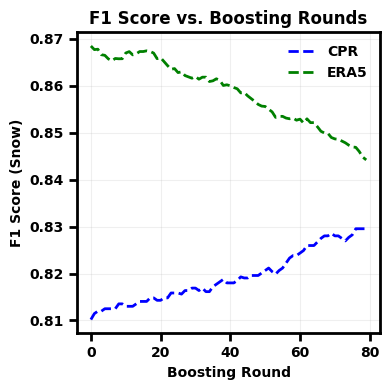

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(f1_test_cpr_snow_values, label='CPR', color='blue', linewidth=2, linestyle='--')
plt.plot(f1_era5_snow_values, label='ERA5', color='green', linewidth=2, linestyle='--')

plt.xlabel('Boosting Round', fontsize=10, fontweight='bold')
plt.ylabel('F1 Score (Snow)', fontsize=10, fontweight='bold')
plt.title('F1 Score vs. Boosting Rounds', fontsize=12, fontweight='bold')

plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight': 'bold'})

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### **2.1.2  ERA5-DPR base learner for classification**

Fine tune the model trained on ERA5 based on Learning from DPR Phase

In [ ]:
# Prepare DPR data
x_train_dpr = df_dpr_phase_train[input_vars]
y_train_dpr = df_dpr_phase_train['Prcp flag']

x_test_dpr = df_dpr_phase_test[input_vars]
y_test_dpr = df_dpr_phase_test['Prcp flag']

# Class weights
classes = np.unique(y_train_dpr)
class_weights = {0: 1, 1: 1.573, 2: 1}

# Sample weights
sample_weights_dpr = y_train_dpr.map(lambda x: class_weights[classes.tolist().index(x)])

# DMatrix creation
dtrain_dpr = xgb.DMatrix(x_train_dpr, label=y_train_dpr, weight=sample_weights_dpr)
dtest_dpr = xgb.DMatrix(x_test_dpr, label=y_test_dpr)
dtest_era5 = xgb.DMatrix(df_era5_phase_test[input_vars], label=df_era5_phase_test['Prcp flag'])

# Eval sets
evals = [(dtrain_dpr, 'train_dpr'), (dtest_dpr, 'test_dpr'), (dtest_era5, 'era5')]

# Tracking F1 scores
f1_train_dpr_rain_values, f1_test_dpr_rain_values, f1_era5_rain_values = [], [], []
f1_train_dpr_snow_values, f1_test_dpr_snow_values, f1_era5_snow_values = [], [], []

# F1 evaluator function
def f1_eval_all_classes(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.argmax(axis=1)
    f1_scores = f1_score(labels, preds, labels=[1, 2], average=None)
    f1_rain, f1_snow = f1_scores[0], f1_scores[1]

    if dtrain == dtrain_dpr:
        f1_train_dpr_rain_values.append(f1_rain)
        f1_train_dpr_snow_values.append(f1_snow)
    elif dtrain == dtest_dpr:
        f1_test_dpr_rain_values.append(f1_rain)
        f1_test_dpr_snow_values.append(f1_snow)
    elif dtrain == dtest_era5:
        f1_era5_rain_values.append(f1_rain)
        f1_era5_snow_values.append(f1_snow)

    return 'f1_rain', f1_rain

# Set model parameters
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'merror',
    'subsample': 0.5,
    'reg_alpha': 6.948,
    'reg_lambda': 5.0278,
    'max_depth': 11,
    'num_parallel_tree': 6,
    'learning_rate': 0.01,
    'gamma': 0.32,
    'verbosity': 0
}

# Fine-tune model with DPR data (warm-start from booster_era5)
booster_dpr = xgb.train(
    params,
    dtrain_dpr,
    num_boost_round=50,
    evals=evals,
    xgb_model=booster_era5,  # warm-start from previously trained model
    verbose_eval=True,
    feval=f1_eval_all_classes
)

# Predict on test set
y_pred_dpr_finetune_proba = booster_dpr.predict(dtest_dpr)
y_pred_dpr_finetune_label = y_pred_dpr_finetune_proba.argmax(axis=1)
# Evaluate final accuracy and F1 score for rain
accuracy = accuracy_score(y_test_dpr, y_pred_dpr_finetune_label)
f1_rain = f1_score(y_test_dpr, y_pred_dpr_finetune_label, labels=[1], average='macro')

print(f"Test accuracy: {accuracy:.2f}")
print(f"F1 score (rain class): {f1_rain:.3f}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train_dpr-merror:0.30763	train_dpr-f1_rain:0.69186	test_dpr-merror:0.34482	test_dpr-f1_rain:0.69929	era5-merror:0.15121	era5-f1_rain:0.84021
[1]	train_dpr-merror:0.30654	train_dpr-f1_rain:0.69269	test_dpr-merror:0.34348	test_dpr-f1_rain:0.70040	era5-merror:0.15136	era5-f1_rain:0.83991
[2]	train_dpr-merror:0.30545	train_dpr-f1_rain:0.69355	test_dpr-merror:0.34196	test_dpr-f1_rain:0.70134	era5-merror:0.15221	era5-f1_rain:0.83880
[3]	train_dpr-merror:0.30418	train_dpr-f1_rain:0.69465	test_dpr-merror:0.34116	test_dpr-f1_rain:0.70194	era5-merror:0.15193	era5-f1_rain:0.83876
[4]	train_dpr-merror:0.30287	train_dpr-f1_rain:0.69569	test_dpr-merror:0.33973	test_dpr-f1_rain:0.70293	era5-merror:0.15221	era5-f1_rain:0.83806
[5]	train_dpr-merror:0.30189	train_dpr-f1_rain:0.69654	test_dpr-merror:0.33902	test_dpr-f1_rain:0.70359	era5-merror:0.15200	era5-f1_rain:0.83817
[6]	train_dpr-merror:0.30079	train_dpr-f1_rain:0.69751	test_dpr-merror:0.33750	test_dpr-f1_rain:0.70458	era5-merror:0.15243	era5-f

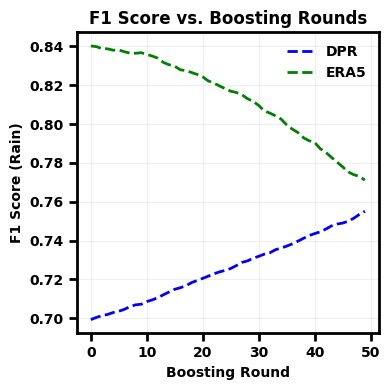

In [ ]:
plt.figure(figsize=(4, 4))

plt.plot(f1_test_dpr_rain_values, label='DPR', color='blue', linewidth=2, linestyle='--')
plt.plot(f1_era5_rain_values, label='ERA5', color='green', linewidth=2, linestyle='--')

plt.xlabel('Boosting Round', fontsize=10, fontweight='bold')
plt.ylabel('F1 Score (Rain)', fontsize=10, fontweight='bold')
plt.title('F1 Score vs. Boosting Rounds', fontsize=12, fontweight='bold')

plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight': 'bold'})
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### **2.1.3  Meta model for label predictions**

Preparing the datasets for the meta model by combining equal number of samples from the satellite and the reanalysis datasets.

In [ ]:
#### Satellite dataset for the meta-model
snow_train_meta_cpr= df_cpr_phase_train[df_cpr_phase_train['Prcp flag']==2]
snow_test_meta_cpr = df_cpr_phase_test[df_cpr_phase_test['Prcp flag']==2]

df_train_sat_meta = shuffle(pd.concat([
    df_cpr_phase_train[df_cpr_phase_train['Prcp flag'] == 2],
    df_dpr_phase_train[df_dpr_phase_train['Prcp flag'] == 1].sample(n=int(2.5 * snow_train_meta_cpr.shape[0]), random_state=42),
    df_cpr_phase_train[df_cpr_phase_train['Prcp flag'] == 0].sample(n=int(1.75 * snow_train_meta_cpr.shape[0]), random_state=42),
    df_dpr_phase_train[df_dpr_phase_train['Prcp flag'] == 0].sample(n=int(1.75 * snow_train_meta_cpr.shape[0]), random_state=42)
], ignore_index=True), random_state=42).reset_index(drop=True)

df_test_sat_meta = shuffle(pd.concat([
    df_cpr_phase_test[df_cpr_phase_test['Prcp flag'] == 2],
    df_dpr_phase_test[df_dpr_phase_test['Prcp flag'] == 1].sample(n=int(2.5 * snow_test_meta_cpr.shape[0]), random_state=42),
    df_cpr_phase_test[df_cpr_phase_test['Prcp flag'] == 0].sample(n=int(1.75 * snow_test_meta_cpr.shape[0]), random_state=42),
    df_dpr_phase_test[df_dpr_phase_test['Prcp flag'] == 0].sample(n=int(1.75 * snow_test_meta_cpr.shape[0]), random_state=42)
], ignore_index=True), random_state=42).reset_index(drop=True)


#### ERA5 dataset for the meta-model
clear_train_meta_era5 = df_era5_phase_train[df_era5_phase_train['Prcp flag']==0].sample(n=int(3.5 * snow_train_meta_cpr.shape[0]), random_state=42)
clear_test_meta_era5= df_era5_phase_test[df_era5_phase_test['Prcp flag']==0].sample(n=int(3.5 * snow_test_meta_cpr.shape[0]), random_state=42)

rain_train_meta_era5= df_era5_phase_train[df_era5_phase_train['Prcp flag']==1].sample(n=int(2.5 * snow_train_meta_cpr.shape[0]), random_state=42)
rain_test_meta_era5= df_era5_phase_test[df_era5_phase_test['Prcp flag']==1].sample(n=int(2.5 * snow_test_meta_cpr.shape[0]), random_state=42)

snow_train_meta_era5 = df_era5_phase_train[df_era5_phase_train['Prcp flag']==2].sample(n=snow_train_meta_cpr.shape[0], random_state=42)
snow_test_meta_era5 = df_era5_phase_test[df_era5_phase_test['Prcp flag']==2].sample(n=snow_test_meta_cpr.shape[0], random_state=42)

df_train_era5_meta = pd.concat([clear_train_meta_era5, rain_train_meta_era5, snow_train_meta_era5], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_test_era5_meta  = pd.concat([clear_test_meta_era5, rain_test_meta_era5, snow_test_meta_era5], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

#### Merging the ERA5 and satellite labels for meta-model
df_train_meta = pd.concat([df_train_era5_meta, df_train_sat_meta], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_test_meta  = pd.concat([df_test_era5_meta, df_test_sat_meta], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

Training the Meta-model

In [ ]:
x_train_get_data_for_meta = df_train_meta[input_vars]
x_test_get_data_for_meta = df_test_meta[input_vars]

dtrain = xgb.DMatrix(x_train_get_data_for_meta)
dtest = xgb.DMatrix(x_test_get_data_for_meta)

## Creating features based on DPR phase probabilities
dpr_pred_proba_for_train = booster_dpr.predict(dtrain)
dpr_pred_proba_for_test = booster_dpr.predict(dtest)

df_train_meta['dpr_p0'], df_train_meta['dpr_p1'], df_train_meta['dpr_p2'] = \
    dpr_pred_proba_for_train[:, 0], dpr_pred_proba_for_train[:, 1], dpr_pred_proba_for_train[:, 2]

df_test_meta['dpr_p0'], df_test_meta['dpr_p1'], df_test_meta['dpr_p2'] = \
    dpr_pred_proba_for_test[:, 0], dpr_pred_proba_for_test[:, 1], dpr_pred_proba_for_test[:, 2]

## Creating features based on CPR phase probabilities
cpr_pred_proba_for_train = booster_cpr.predict(dtrain)
cpr_pred_proba_for_test = booster_cpr.predict(dtest)

df_train_meta['cpr_p0'], df_train_meta['cpr_p1'], df_train_meta['cpr_p2'] = \
    cpr_pred_proba_for_train[:, 0], cpr_pred_proba_for_train[:, 1], cpr_pred_proba_for_train[:, 2]

df_test_meta['cpr_p0'], df_test_meta['cpr_p1'], df_test_meta['cpr_p2'] = \
    cpr_pred_proba_for_test[:, 0], cpr_pred_proba_for_test[:, 1], cpr_pred_proba_for_test[:, 2]

[0]	train-mlogloss:0.79438	train-merror:0.13252	test-mlogloss:0.82272	test-merror:0.19215
[1]	train-mlogloss:0.62762	train-merror:0.13044	test-mlogloss:0.67617	test-merror:0.19062
[2]	train-mlogloss:0.52356	train-merror:0.12820	test-mlogloss:0.58841	test-merror:0.19052
[3]	train-mlogloss:0.45469	train-merror:0.12660	test-mlogloss:0.53297	test-merror:0.19113
[4]	train-mlogloss:0.40738	train-merror:0.12558	test-mlogloss:0.49721	test-merror:0.19154
[5]	train-mlogloss:0.37384	train-merror:0.12482	test-mlogloss:0.47393	test-merror:0.19011
[6]	train-mlogloss:0.34969	train-merror:0.12398	test-mlogloss:0.45880	test-merror:0.19052
[7]	train-mlogloss:0.33139	train-merror:0.12246	test-mlogloss:0.44891	test-merror:0.19072
[8]	train-mlogloss:0.31766	train-merror:0.12076	test-mlogloss:0.44185	test-merror:0.19164
[9]	train-mlogloss:0.30702	train-merror:0.11999	test-mlogloss:0.43668	test-merror:0.19103
[10]	train-mlogloss:0.29859	train-merror:0.11933	test-mlogloss:0.43291	test-merror:0.19113
[11]	trai

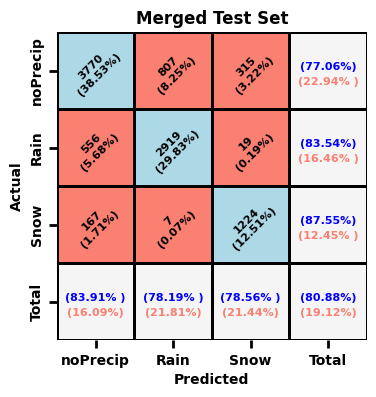

In [ ]:
new_input_vars = ['dpr_p0', 'dpr_p1', 'dpr_p2', 'cpr_p0', 'cpr_p1', 'cpr_p2']

x_train_meta = df_train_meta[new_input_vars]
y_train_meta = df_train_meta['Prcp flag']

x_test_meta = df_test_meta[new_input_vars]
y_test_meta = df_test_meta['Prcp flag']

# Prepare the DMatrix for train and test data
dtrain_meta = xgb.DMatrix(x_train_meta, label=y_train_meta)
dtest_meta = xgb.DMatrix(x_test_meta, label=y_test_meta)

# Define evaluation metrics, watchlist to monitor test metrics
evals = [(dtrain_meta, 'train'), (dtest_meta, 'test')]

params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': ['mlogloss', 'merror'],
    'subsample': 0.5,
    'reg_alpha': 0.095,
    'reg_lambda': 7.843,
    'max_depth': 15,
    'num_parallel_tree': 3,
    'learning_rate': 0.330808,
    'gamma': 0.661776,
    'verbosity': 1
}

# Train the model (meta_model)
meta_model = xgb.train(
    params=params,
    dtrain=dtrain_meta,
    evals=evals,
    num_boost_round=20,
    verbose_eval=True
)

# Predict probabilities
y_pred_proba = meta_model.predict(dtest_meta)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test_meta, y_pred, 'Predicted', 'Actual', 'Merged Test Set')

### **2.1.4  ERA5-CPR base learner for snowfall retrievals**

Training the base learner for the snow rate estimation by first learning the ERA5 and then fine tuning on CloudSat snow rate

In [ ]:
X_train_snow_era5 = df_era5_snow_rate_train[input_vars]
y_train_snow_era5 = df_era5_snow_rate_train['snow_rate']

X_test_snow_era5 = df_era5_snow_rate_test[input_vars]
y_test_snow_era5 = df_era5_snow_rate_test['snow_rate']



# Convert to DMatrix format
dtrain_snow_era5 = xgb.DMatrix(X_train_snow_era5, label=y_train_snow_era5)
dtest_snow_era5 = xgb.DMatrix(X_test_snow_era5, label=y_test_snow_era5)


# Define evaluation metrics and watchlist
evals = [(dtrain_snow_era5, 'train'), (dtest_snow_era5, 'test')]

evals_result = {}

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'learning_rate': 0.0392,
    'max_depth': 14,
    'reg_alpha': 4.52,
    'reg_lambda': 7.139,
    'n_estimators': 52,
    'num_parallel_tree': 6,
    'eval_metric': ['rmse']
}

# Train the model with early stopping
xgb_reg_snow_era5 = xgb.train(params, dtrain_snow_era5, num_boost_round=52, evals=evals, evals_result=evals_result, early_stopping_rounds=5)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.20422	test-rmse:0.20202
[1]	train-rmse:0.19941	test-rmse:0.19753
[2]	train-rmse:0.19483	test-rmse:0.19331
[3]	train-rmse:0.19048	test-rmse:0.18929
[4]	train-rmse:0.18636	test-rmse:0.18532
[5]	train-rmse:0.18241	test-rmse:0.18157
[6]	train-rmse:0.17859	test-rmse:0.17794
[7]	train-rmse:0.17495	test-rmse:0.17466
[8]	train-rmse:0.17155	test-rmse:0.17149
[9]	train-rmse:0.16825	test-rmse:0.16837
[10]	train-rmse:0.16514	test-rmse:0.16550
[11]	train-rmse:0.16212	test-rmse:0.16258
[12]	train-rmse:0.15923	test-rmse:0.15982
[13]	train-rmse:0.15648	test-rmse:0.15729
[14]	train-rmse:0.15389	test-rmse:0.15482
[15]	train-rmse:0.15137	test-rmse:0.15254
[16]	train-rmse:0.14901	test-rmse:0.15045
[17]	train-rmse:0.14665	test-rmse:0.14838
[18]	train-rmse:0.14446	test-rmse:0.14643
[19]	train-rmse:0.14232	test-rmse:0.14455
[20]	train-rmse:0.14022	test-rmse:0.14287
[21]	train-rmse:0.13824	test-rmse:0.14116
[22]	train-rmse:0.13641	test-rmse:0.13952
[23]	train-rmse:0.13461	test-rmse:0.13810
[2

Fine tuning the model based on CPR snow rate

In [ ]:
X_train_snow_sat = df_cpr_snow_rate_train[input_vars]
y_train_snow_sat = df_cpr_snow_rate_train['snow_rate']
X_test_snow_sat = df_cpr_snow_rate_test[input_vars]
y_test_snow_sat = df_cpr_snow_rate_test['snow_rate']

dtrain_snow_rate_sat = xgb.DMatrix(X_train_snow_sat, label=y_train_snow_sat)
dtest_snow_rate_sat = xgb.DMatrix(X_test_snow_sat, label=y_test_snow_sat)

evals = [(dtest_snow_era5, 'test_era5'), (dtest_snow_rate_sat, 'test_sat'), (dtrain_snow_rate_sat, 'train_sat')]
evals_result = {}

# Set parameters for fine-tuning
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.014,
    'eval_metric': 'rmse',
    'max_depth': 15
}

# Continue training with the new data
snow_rate_booster = xgb.train(
    params,
    dtrain_snow_rate_sat,
    num_boost_round=104,
    evals=evals,
    xgb_model=xgb_reg_snow_era5,
    evals_result=evals_result,
    verbose_eval=True
)


y_pred_snow_rate_sat = snow_rate_booster.predict(dtest_snow_rate_sat)

mse_new = mean_squared_error(y_test_snow_sat, y_pred_snow_rate_sat)
print(f"Test Mean Squared Error: {mse_new:.2f}")

[0]	test_era5-rmse:0.11892	test_sat-rmse:0.38786	train_sat-rmse:0.32433
[1]	test_era5-rmse:0.11875	test_sat-rmse:0.38672	train_sat-rmse:0.32287
[2]	test_era5-rmse:0.11861	test_sat-rmse:0.38560	train_sat-rmse:0.32141
[3]	test_era5-rmse:0.11851	test_sat-rmse:0.38450	train_sat-rmse:0.31995
[4]	test_era5-rmse:0.11842	test_sat-rmse:0.38342	train_sat-rmse:0.31853
[5]	test_era5-rmse:0.11835	test_sat-rmse:0.38238	train_sat-rmse:0.31715
[6]	test_era5-rmse:0.11831	test_sat-rmse:0.38134	train_sat-rmse:0.31578
[7]	test_era5-rmse:0.11830	test_sat-rmse:0.38030	train_sat-rmse:0.31443
[8]	test_era5-rmse:0.11828	test_sat-rmse:0.37933	train_sat-rmse:0.31309
[9]	test_era5-rmse:0.11823	test_sat-rmse:0.37832	train_sat-rmse:0.31175
[10]	test_era5-rmse:0.11824	test_sat-rmse:0.37738	train_sat-rmse:0.31045
[11]	test_era5-rmse:0.11829	test_sat-rmse:0.37641	train_sat-rmse:0.30913
[12]	test_era5-rmse:0.11831	test_sat-rmse:0.37548	train_sat-rmse:0.30785
[13]	test_era5-rmse:0.11837	test_sat-rmse:0.37449	train_sat-r

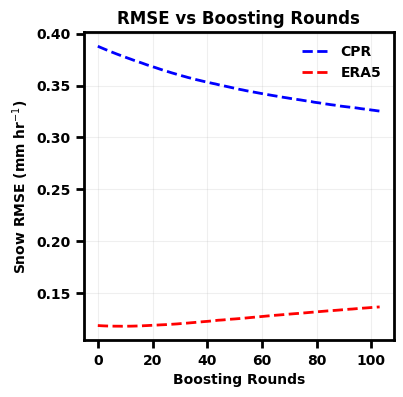

In [ ]:
# Extract RMSE values
train_rmse = evals_result['test_sat']['rmse']
test_rmse = evals_result['test_era5']['rmse']

# Plot RMSE vs Boosting rounds
plt.figure(figsize=(4, 4))
plt.plot(train_rmse, label='CPR', color='blue', linestyle='--', linewidth=2)
plt.plot(test_rmse, label='ERA5', color='red', linestyle='--', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=10, fontweight='bold')
plt.ylabel('Snow RMSE (mm hr$^{-1}$)', fontsize=10, fontweight='bold')


plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)
plt.title('RMSE vs Boosting Rounds', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight':'bold'})
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.grid(True, alpha=0.2)
plt.show()

### **2.1.5  ERA5-DPR base learner for rain retrievals**

Training the base learner for the rain rate estimation by first learning the ERA5 rain and then fine tuning on DPR datasets.

In [ ]:
# Prepare training and testing datasets
X_train_rain_era5 = df_era5_rain_rate_train[input_vars]
y_train_rain_era5 = df_era5_rain_rate_train['DPR rain Rate']

X_test_rain_era5 = df_era5_rain_rate_test[input_vars]
y_test_rain_era5 = df_era5_rain_rate_test['DPR rain Rate']

# Convert to DMatrix format
dtrain_rain_era5 = xgb.DMatrix(X_train_rain_era5, label=y_train_rain_era5)
dtest_rain_era5 = xgb.DMatrix(X_test_rain_era5, label=y_test_rain_era5)

# Define evaluation metrics and watchlist
evals = [(dtrain_rain_era5, 'train'), (dtest_rain_era5, 'test')]
evals_result = {}

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'learning_rate': 0.0392,
    'max_depth': 14,
    'reg_alpha': 4.52,
    'reg_lambda': 7.139,
    'n_estimators': 52,
    'num_parallel_tree': 6,
    'eval_metric': ['rmse']
}

# Train the model with early stopping
xgb_reg_rain_era5 = xgb.train(
    params,
    dtrain_rain_era5,
    num_boost_round=52,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=5
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:54:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.60552	test-rmse:0.65906
[1]	train-rmse:0.59299	test-rmse:0.64787
[2]	train-rmse:0.58105	test-rmse:0.63739
[3]	train-rmse:0.56963	test-rmse:0.62747
[4]	train-rmse:0.55847	test-rmse:0.61808
[5]	train-rmse:0.54781	test-rmse:0.60915
[6]	train-rmse:0.53751	test-rmse:0.60066
[7]	train-rmse:0.52776	test-rmse:0.59303
[8]	train-rmse:0.51830	test-rmse:0.58549
[9]	train-rmse:0.50920	test-rmse:0.57824
[10]	train-rmse:0.50036	test-rmse:0.57056
[11]	train-rmse:0.49195	test-rmse:0.56388
[12]	train-rmse:0.48386	test-rmse:0.55775
[13]	train-rmse:0.47606	test-rmse:0.55228
[14]	train-rmse:0.46854	test-rmse:0.54733
[15]	train-rmse:0.46134	test-rmse:0.54249
[16]	train-rmse:0.45410	test-rmse:0.53730
[17]	train-rmse:0.44741	test-rmse:0.53274
[18]	train-rmse:0.44091	test-rmse:0.52759
[19]	train-rmse:0.43438	test-rmse:0.52313
[20]	train-rmse:0.42814	test-rmse:0.51874
[21]	train-rmse:0.42234	test-rmse:0.51479
[22]	train-rmse:0.41646	test-rmse:0.51132
[23]	train-rmse:0.41092	test-rmse:0.50774
[2

In [ ]:
# Prepare training and testing datasets
X_train_rain_dpr = df_dpr_rain_rate_train[input_vars]
y_train_rain_dpr = df_dpr_rain_rate_train['DPR rain Rate']
X_test_rain_dpr = df_dpr_rain_rate_test[input_vars]
y_test_rain_dpr = df_dpr_rain_rate_test['DPR rain Rate']

# Convert to DMatrix format
dtrain_rain_rate_dpr = xgb.DMatrix(X_train_rain_dpr, label=y_train_rain_dpr)
dtest_rain_rate_dpr = xgb.DMatrix(X_test_rain_dpr, label=y_test_rain_dpr)

# Define evaluation datasets
evals = [(dtest_rain_era5, 'test_era5'), (dtest_rain_rate_dpr, 'test_dpr'), (dtrain_rain_rate_dpr, 'train_dpr')]
evals_result = {}

# Set parameters for fine-tuning
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'eval_metric': 'rmse',
    'max_depth': 15
}

# Continue training with the new data
rain_rate_booster = xgb.train(
    params,
    dtrain_rain_rate_dpr,
    num_boost_round=104,
    evals=evals,
    xgb_model=xgb_reg_rain_era5,  # pretrained model from ERA5
    evals_result=evals_result,
    verbose_eval=True
)

# Make predictions
y_pred_rain_rate_dpr = rain_rate_booster.predict(dtest_rain_rate_dpr)

# Evaluate performance
mse_new = mean_squared_error(y_test_rain_dpr, y_pred_rain_rate_dpr)
print(f"Test Mean Squared Error: {mse_new:.2f}")

[0]	test_era5-rmse:0.45387	test_dpr-rmse:2.62830	train_dpr-rmse:2.60645
[1]	test_era5-rmse:0.45416	test_dpr-rmse:2.61465	train_dpr-rmse:2.59098
[2]	test_era5-rmse:0.45460	test_dpr-rmse:2.60117	train_dpr-rmse:2.57567
[3]	test_era5-rmse:0.45504	test_dpr-rmse:2.58805	train_dpr-rmse:2.56047
[4]	test_era5-rmse:0.45560	test_dpr-rmse:2.57492	train_dpr-rmse:2.54547
[5]	test_era5-rmse:0.45619	test_dpr-rmse:2.56219	train_dpr-rmse:2.53063
[6]	test_era5-rmse:0.45698	test_dpr-rmse:2.54969	train_dpr-rmse:2.51594
[7]	test_era5-rmse:0.45759	test_dpr-rmse:2.53672	train_dpr-rmse:2.50115
[8]	test_era5-rmse:0.45833	test_dpr-rmse:2.52448	train_dpr-rmse:2.48679
[9]	test_era5-rmse:0.45926	test_dpr-rmse:2.51244	train_dpr-rmse:2.47253
[10]	test_era5-rmse:0.46022	test_dpr-rmse:2.49987	train_dpr-rmse:2.45820
[11]	test_era5-rmse:0.46126	test_dpr-rmse:2.48837	train_dpr-rmse:2.44424
[12]	test_era5-rmse:0.46246	test_dpr-rmse:2.47697	train_dpr-rmse:2.43046
[13]	test_era5-rmse:0.46367	test_dpr-rmse:2.46488	train_dpr-r

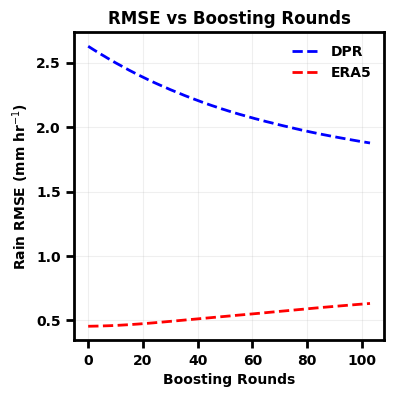

In [ ]:
# Extract RMSE values
train_rmse = evals_result['test_dpr']['rmse']
test_rmse = evals_result['test_era5']['rmse']

# Plot RMSE vs Boosting rounds
plt.figure(figsize=(4, 4))
plt.plot(train_rmse, label='DPR', color='blue', linestyle='--', linewidth=2)
plt.plot(test_rmse, label='ERA5', color='red', linestyle='--', linewidth=2)

plt.xlabel('Boosting Rounds', fontsize=10, fontweight='bold')
plt.ylabel('Rain RMSE (mm hr$^{-1}$)', fontsize=10, fontweight='bold')


plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)
plt.title('RMSE vs Boosting Rounds', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight':'bold'})
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.grid(True, alpha=0.2)
plt.show()

# **3.  Orbial Retrievals**

In this section, the pre-trained models are loaded to retrieve rainfall and snowfall for two GMI orbits.

## **3.1) Running B-RAINS for the selected orbit**

In [ ]:
path_orbit_004780 = 'Orbit_004780/GPM_orbit_004780.npz'

# Load the .npz file
npz_004780 = np.load(path_orbit_004780)

In [ ]:
[phase, rain, snow, latitude, longitude] = BRAINS_model(path_orbit_004780, booster_cpr, booster_dpr, meta_model,
                     snow_rate_booster, rain_rate_booster,
                     df_cdf_rain, df_cdf_snow);

/content/Microwave_Precipitation_Retrievals_from_B-RAINS/Microwave_Precipitation_Retrievals_from_B-RAINS/pmw_utils.py:280: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0388816  0.11648546 0.10300759 ... 0.06047127 0.06047127 0.04033583]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_snowr.index, 'pred_snow_rate'] = actual_snow_values
/content/Microwave_Precipitation_Retrievals_from_B-RAINS/Microwave_Precipitation_Retrievals_from_B-RAINS/pmw_utils.py:290: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.002681   0.01116959 0.02735633 ... 0.01256065 0.02160131 0.01348722]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_rainr.index, 'pred_rain_rate'] = actual_rain_values


In [ ]:
!pip install cartopy
import cartopy.crs as ccrs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 93.2 MB/s eta 0:00:00


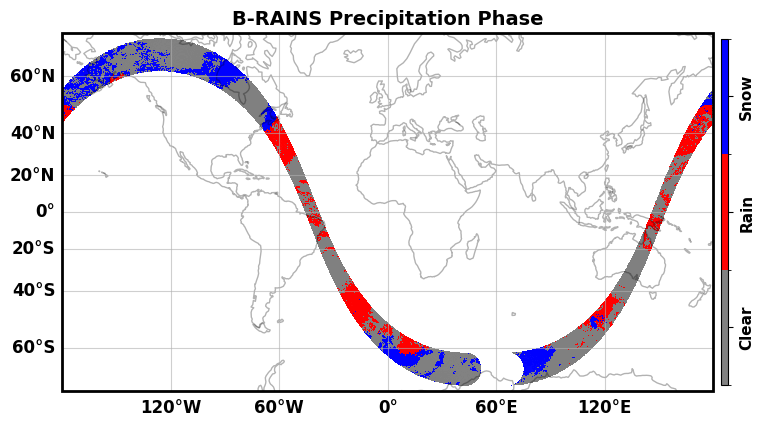

In [ ]:
cmap_custom = mcolors.ListedColormap(['grey', 'red', 'blue'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap_custom.N)

# Create figure for ERA5_flag
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111, projection=ccrs.Mercator())

mask = (longitude > 179.5) | (longitude < -179.5)
ERA5_flag_2d_masked = np.ma.masked_where(mask, phase)

# Plot using pcolormesh
plot1 = ax1.pcolormesh(longitude, latitude, ERA5_flag_2d_masked, cmap=cmap_custom, norm=norm, alpha=0.98, transform=ccrs.PlateCarree())
ax1.coastlines(alpha=0.3)

g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
g4.top_labels = False
g4.right_labels = False
g4.xlabels_bottom = True
g4.ylabels_left = True
g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}


cbar1 = plt.colorbar(plot1, ax=ax1, orientation='vertical', shrink=0.75, pad=0.01, aspect=50)
cbar1.set_ticks([0.5, 1.5, 2.5])
cbar1.set_ticklabels(['Clear', 'Rain', 'Snow'])
for t in cbar1.ax.get_yticklabels():
    t.set_fontweight('bold')
    t.set_fontsize(11)
    t.set_rotation(90)
    t.set_ha('center')
    t.set_va('center')
cbar1.ax.tick_params(pad=10)
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
ax1.set_title('B-RAINS Precipitation Phase', fontsize=14, fontweight='bold')


plt.show()

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


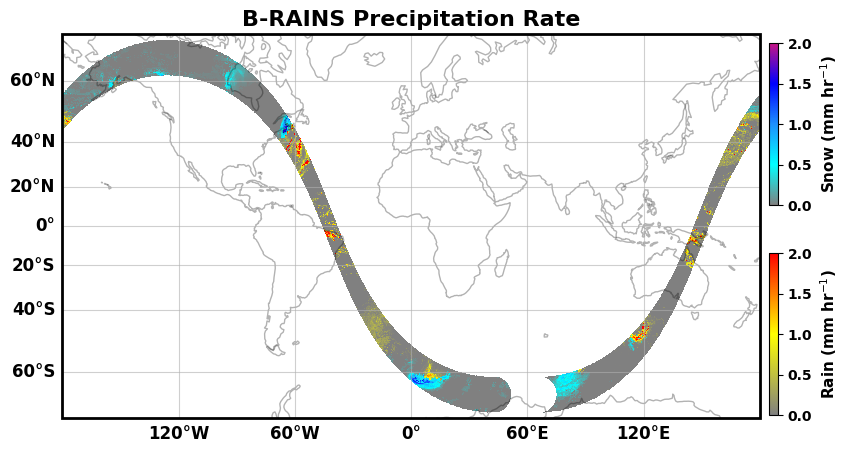

In [ ]:
# Define color maps
from matplotlib.colors import LinearSegmentedColormap
colors_snow = ['grey', 'cyan', 'dodgerblue', 'blue', 'mediumvioletred']
cmap_rate_snow = LinearSegmentedColormap.from_list("mycmap_snow", colors_snow)

colors_rain = ['grey', 'yellow', 'red']
cmap_rate_rain = LinearSegmentedColormap.from_list("mycmap_rain", colors_rain)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.Mercator()})
mask = (longitude > 179.5) | (longitude < -179.5)

snow_masked = np.ma.masked_where(mask, snow)
rain_masked = np.ma.masked_where(mask, rain)

snow_rate_masked = np.ma.masked_where(rain_masked > snow_masked, snow)
rain_rate_masked = np.ma.masked_where(snow_masked > rain_masked, rain)

# Plot snow and rain
plot1 = ax1.pcolormesh(longitude, latitude, snow_rate_masked, vmin=0, vmax=2,
                       cmap=cmap_rate_snow, transform=ccrs.PlateCarree())
plot2 = ax1.pcolormesh(longitude, latitude, rain_rate_masked, vmin=0, vmax=2,
                       cmap=cmap_rate_rain, transform=ccrs.PlateCarree())

# Coastlines and grid
ax1.coastlines(alpha=0.3)
g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
g4.top_labels = False
g4.right_labels = False
g4.xlabels_bottom = True
g4.ylabels_left = True
g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
ax1.set_title('B-RAINS Precipitation Rate', fontsize=16, fontweight='bold')


cbar_ax1 = fig.add_axes([0.91, 0.53, 0.01, 0.27])
cbar_ax2 = fig.add_axes([0.91, 0.18, 0.01, 0.27])

cbar1 = fig.colorbar(plot1, cax=cbar_ax1)
cbar1.set_label('Snow (mm hr$^{-1}$)', fontsize=11, fontweight='bold')
for t in cbar1.ax.get_yticklabels():
    t.set_fontweight('bold')

cbar2 = fig.colorbar(plot2, cax=cbar_ax2)
cbar2.set_label('Rain (mm hr$^{-1}$)', fontsize=11, fontweight='bold')
for t in cbar2.ax.get_yticklabels():
    t.set_fontweight('bold')

plt.show()

<ipython-input-34-31d522f5542c>:109: RuntimeWarning: divide by zero encountered in log2
  im7 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(rain_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
<ipython-input-34-31d522f5542c>:112: RuntimeWarning: divide by zero encountered in log2
  im7_1 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(snow_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
<ipython-input-34-31d522f5542c>:122: RuntimeWarning: divide by zero encountered in log2
  im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
<ipython-input-34-31d522f5542c>:122: RuntimeWarning: invalid value encountered in log2
  im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
<ipython-input-34-31d522f5542c>:126: RuntimeWarning: divide by zero

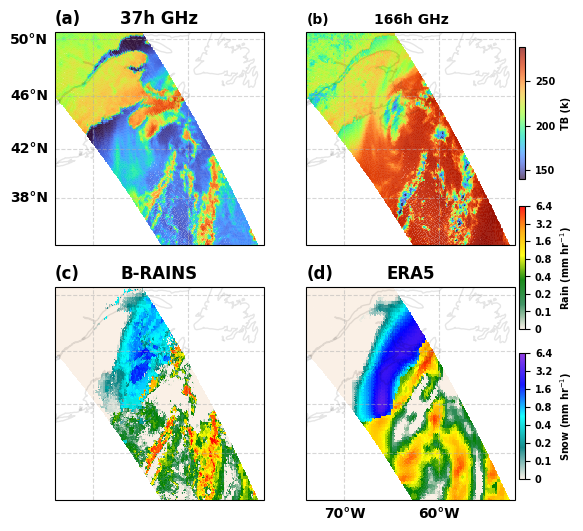

In [ ]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from matplotlib.colors import PowerNorm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, LogNorm
from matplotlib.ticker import LogLocator, FuncFormatter
import warnings
#import colorcet as cc

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy.mpl.gridliner")


#colors_1 = ['grey', 'lawngreen', 'gold', 'darkorange']
colors_1 = ['linen', 'seagreen' ,'green', 'yellow', 'orange', 'red']



rate_colors = ['linen', 'teal', 'cyan', 'blue', 'blueviolet']  # For snow_rate plots

rate_bt = ['lightblue', 'teal','cyan', 'green', 'yellowgreen','yellow', 'red']

# Create colormap objects
cmap_rain = LinearSegmentedColormap.from_list("mycmap_rain", colors_1, N=256)
cmap_snow = LinearSegmentedColormap.from_list("mycmap_snow", rate_colors)
cmap_bt = LinearSegmentedColormap.from_list("mycmap_snow", rate_bt)


new_cmap = cmap_rain
my_cmap = cmap_snow


# Mask data based on lon_2d values
mask = (longitude > -52) | (longitude < -74)

snow_rate_masked = np.ma.masked_where(rain_masked > snow_masked, snow)
rain_rate_masked = np.ma.masked_where(snow_masked > rain_masked, rain)

snow_pred_2d = np.ma.masked_where(mask, snow)
rain_pred_2d = np.ma.masked_where(mask, rain)
snow_rate_masked = np.ma.masked_where(rain_pred_2d > snow_pred_2d, snow)
rain_rate_masked = np.ma.masked_where(snow_pred_2d > rain_pred_2d, rain)


snow_era5 = npz_004780['snow_era5']
rain_era5= npz_004780['rain_era5']
snow_era5_2d = np.ma.masked_where(mask, snow_era5)
rain_era5_2d = np.ma.masked_where(mask, rain_era5)

snow_rate_era5_masked = np.ma.masked_where(rain_era5_2d > snow_era5_2d, snow_era5)
rain_rate_era5_masked = np.ma.masked_where(snow_era5_2d > rain_era5_2d, rain_era5)



tb_37h= npz_004780['36h']
tb_166h= npz_004780['166h']
tb_37h_2d = np.ma.masked_where(mask, tb_37h)
tb_166h_2d = np.ma.masked_where(mask, tb_166h)
# Plotting
fig, axes = plt.subplots(
    2, 2, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()},
    gridspec_kw={'height_ratios': [1, 1], 'left': 0.05, 'bottom': 0.2,
                 'right': 0.85, 'top': 0.98, 'hspace': 0.2, 'wspace': 0.1})

import matplotlib.ticker as mticker  # Ensure mticker is imported

# Helper function to configure gridlines with custom intervals
def configure_gridlines(ax, x_bottom=True, y_left=True, lat_interval=10, lon_interval=10):
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = y_left
    gl.bottom_labels = x_bottom

    # Set custom intervals for latitude and longitude labels
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, lon_interval))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, lat_interval))
    ax.set_xticks(np.arange(-180, 181, lon_interval))
    ax.set_yticks(np.arange(-90, 91, lat_interval))


    gl.xlabel_style = {'fontsize': 10, 'fontweight': 'bold'}
    gl.ylabel_style = {'fontsize': 10, 'fontweight': 'bold'}



# Plot 1: 37h
im1 = axes[0, 0].pcolormesh(longitude, latitude, tb_37h_2d,  vmin=140, vmax=288,
                            cmap= 'turbo', alpha=0.7, transform=ccrs.PlateCarree())
axes[0, 0].coastlines(alpha=0.1)
configure_gridlines(axes[0, 0], lat_interval=4, lon_interval=10, y_left=True, x_bottom=False)
axes[0, 0].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[0, 0].set_title('37h GHz', fontsize=12, fontweight='bold')
axes[0, 0].set_title('(a)', fontsize=12, fontweight='bold', loc='left')

# Plot 4: 166h
im3 = axes[0, 1].pcolormesh(longitude, latitude, tb_166h_2d, vmin=140, vmax=288,
                            cmap= 'turbo', alpha=0.7, transform=ccrs.PlateCarree())
axes[0, 1].coastlines(alpha=0.1)
configure_gridlines(axes[0, 1], lat_interval=4, lon_interval=10, y_left=False, x_bottom=False)
axes[0, 1].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[0, 1].set_title('166h GHz', fontsize=10, fontweight='bold')
axes[0, 1].set_title('(b)', fontsize=10, fontweight='bold', loc='left')

# Plot 6: Rain and snow from B-RAIN
im7 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(rain_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=new_cmap, alpha=0.9, transform=ccrs.PlateCarree())
snow_pred_2d = np.where(snow_pred_2d < rain_pred_2d, np.nan, snow_pred_2d)
im7_1 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(snow_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=cmap_snow, alpha=0.9, transform=ccrs.PlateCarree())
axes[1, 0].coastlines(alpha=0.1)
configure_gridlines(axes[1, 0], lat_interval=4 , lon_interval=10, y_left=False, x_bottom=False)
axes[1, 0].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[1, 0].set_title('B-RAINS', fontsize=12, fontweight='bold')
axes[1, 0].set_title('(c)', fontsize=12, fontweight='bold', loc='left')


# Plot 5: Rain and snow from ERA5
im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=new_cmap, alpha=0.9, transform=ccrs.PlateCarree())
snow_era5_2d = np.where(snow_era5_2d < rain_era5_2d, np.nan, snow_era5_2d)

im4_1 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(snow_rate_era5_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=cmap_snow, alpha=0.9, transform=ccrs.PlateCarree())
axes[1, 1].coastlines(alpha=0.1)
configure_gridlines(axes[1, 1], lat_interval=4, lon_interval=10, y_left=False, x_bottom=True)
axes[1, 1].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[1, 1].set_title('ERA5', fontsize=12, fontweight='bold')
axes[1, 1].set_title('(d)', fontsize=12, fontweight='bold', loc='left')

from matplotlib import ticker

# Upper row colorbar (Snow Rate)
cbar_ax1 = fig.add_axes([0.84, 0.735, 0.01, 0.22])  # Position for the upper row colorbar
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical')
cbar1.set_label('TB (k)', fontsize=7, fontweight='bold')

# Set tick label properties
for tick in cbar1.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')

############################################################################################################
cbar_ax2 = fig.add_axes([0.84, 0.485, 0.01, 0.205])
cbar2 = fig.colorbar(im4, cax=cbar_ax2, orientation='vertical', label='Rain Rate (mm hr$^{{-1}}$)')
rain_ticks = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
log_ticks = np.log2(np.clip(rain_ticks, 1e-10, None))

cbar2.set_ticks(log_ticks)

tick_labels = ['0' if tick == 0.05 else f"{tick:.1f}" for tick in rain_ticks]
cbar2.set_ticklabels([f"{tick}" for tick in tick_labels])

# Set tick label properties
for tick in cbar2.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')


cbar2.set_label('Rain (mm hr$^{-1}$)', fontsize=7, fontweight='bold')
###########################################################################################
cbar_ax3 = fig.add_axes([0.84, 0.235, 0.01, 0.21])
cbar3 = fig.colorbar(im7_1, cax=cbar_ax3, orientation='vertical')
snow_ticks = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
log_ticks = np.log2(np.clip(snow_ticks, 1e-10, None))

cbar3.set_ticks(log_ticks)

tick_labels = ['0' if tick == 0.05 else f"{tick:.1f}" for tick in snow_ticks]
cbar3.set_ticklabels([f"{tick}" for tick in tick_labels])

# Set tick label properties
for tick in cbar3.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')


cbar3.set_label('Snow (mm hr$^{-1}$)', fontsize=7, fontweight='bold')


plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()